In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sodapy import Socrata


## Downloading Data from API 

Socrata is apparently the host for all of NYC's open data. I generated a key so that we wouldn't get throttled for downloading millions of entries. Basically this part just downloads all of the uber trip data during January 2020 (around 14 million records).

In [21]:
import time

def cleanup_func(trip_df):
    tdf = trip_df.copy()
    tdf.pulocationid = tdf.pulocationid.astype(int)
    tdf.dolocationid = tdf.dolocationid.astype(int)
    tdf.pickup_datetime = pd.to_datetime(tdf.pickup_datetime)
    tdf.dropoff_datetime = pd.to_datetime(tdf.dropoff_datetime)
    return tdf

In [2]:
#dont run this cell if data is already  in folder
tic = time.time()
with Socrata('data.cityofnewyork.us', 'vA3MfkSw5kKhpzNkitJkv5yFP') as client:
    #gets the taxi zones (the geometry of each zone in the city + the zone name and borough)
    taxi_zones =  pd.DataFrame.from_records(client.get_all('755u-8jsi'))
    
    #run through all the uber results in jan 2020/feb 2020 (pre-pandemic and there's no data in 2021)
    high_volume_query = client.get('yrt9-58g8',
                                   limit = 20000000,
                                   where = 'hvfhs_license_num = "HV0003" and pickup_datetime < "2020-02-01" and pickup_datetime > "2020-01-01"')
    
    trips = cleanup_func(pd.DataFrame.from_records(high_volume_query))
print(time.time() - tic)

1268.1834218502045


In [45]:
#run this cell instead if the data is already in folder

with Socrata('data.cityofnewyork.us', 'vA3MfkSw5kKhpzNkitJkv5yFP') as client:
    #gets the taxi zones (the geometry of each zone in the city + the zone name and borough)
    taxi_zones =  pd.DataFrame.from_records(client.get_all('755u-8jsi'))
    
trips = cleanup_func(pd.read_csv('january-2020-uber-data.csv', index_col = 0))


/usr/local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There appears to be 262 distinct zones recorded, and there are some zones in the trips dataset not in here, so remove those trips from  trips.

In [46]:
taxi_zones

,objectid,shape_leng,the_geom,shape_area,zone,location_id,borough
0,1,0.116357453189,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.0007823067885,Newark Airport,1,EWR
1,2,0.43346966679,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.00486634037837,Jamaica Bay,2,Queens
2,3,0.0843411059012,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000314414156821,Allerton/Pelham Gardens,3,Bronx
3,4,0.0435665270921,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000111871946192,Alphabet City,4,Manhattan
4,5,0.0921464898574,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000497957489363,Arden Heights,5,Staten Island
...,...,...,...,...,...,...,...
258,256,0.0679149669603,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000168611097013,Williamsburg (South Side),256,Brooklyn
259,259,0.126750305191,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000394552487366,Woodlawn/Wakefield,259,Bronx
260,260,0.133514154636,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000422345326907,Woodside,260,Queens
261,261,0.0271204563616,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.0000343423231652,World Trade Center,261,Manhattan


In [47]:
trips = trips[(trips.pulocationid.isin(taxi_zones.location_id.astype(int))) & (trips.dolocationid.isin(taxi_zones.location_id.astype(int)))]

## Some Visual Examination of Time-Varying Pickups/Service Times

In [49]:
#first examine distribution differences of trips per day/week across January
#then examine distribution differences within each day
#examine distributions of pickups across zones
#14 million trips in january 2020

trips['dayofweek'] = trips.pickup_datetime.dt.dayofweek
trips['day'] = trips.pickup_datetime.dt.day
day_groups = trips.groupby('day')
trips_by_day = day_groups['hvfhs_license_num'].count()

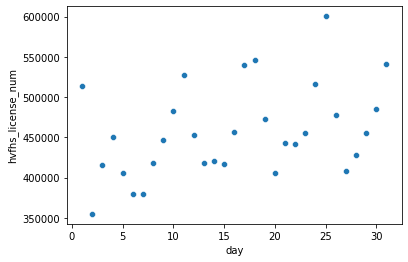

In [50]:
_ = sns.scatterplot(data = trips_by_day)
#definitely a little seasonality

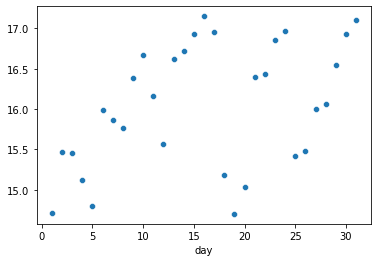

In [51]:
avg_trip_length = day_groups.apply(lambda group: (group.dropoff_datetime - group.pickup_datetime).mean().seconds / 60)
_ = sns.scatterplot(data = avg_trip_length)

In [52]:
trips[['hvfhs_license_num','dispatching_base_num','pickup_datetime','dropoff_datetime','pulocationid','dolocationid']].to_csv('january-2020-uber-data.csv')

In [53]:
#group by hour
trips['hour'] = trips.pickup_datetime.dt.hour
hour_groups = trips.groupby('hour')
trips_by_hour = hour_groups['hvfhs_license_num'].count()

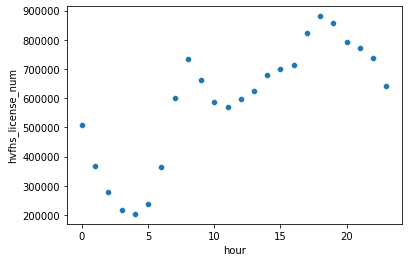

In [54]:
_ = sns.scatterplot(data = trips_by_hour)

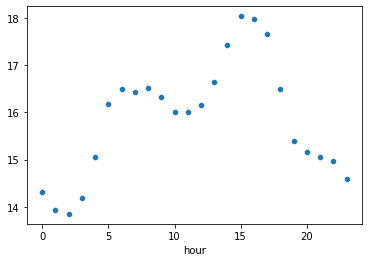

In [55]:
#average trip length by hour
avg_trip_length_hourly = hour_groups.apply(lambda group: 
                                           (group.dropoff_datetime - group.pickup_datetime).mean().seconds / 60)
_ = sns.scatterplot(data = avg_trip_length_hourly)

## Extracting Distributions

In [56]:
#eventually need to discover these things:
#time varying rate of arrivals over time by the hour for a whole month
#time varying rate of arrivals for each zone
#the distribution of dropoff zones for each pickup zone (where the customer is going)
#distribution of service times for each pickup - dropoff zone

#group by zones
zone_groups = trips.groupby('pulocationid')

In [57]:
#check the zone -> zone distribution
zone_to_zone = pd.crosstab(index = trips.pulocationid, columns = trips.dolocationid)

The below graph shows the number of pickups in each zone (265 total) in January 2020. Very long-tailed, a few high-frequency areas. We could maybe group together zones to reduce computation times but that would require some more analysis/clustering so it might be best to just stick with the 265 zones for simpler system logic.

<AxesSubplot:xlabel='pulocationid'>

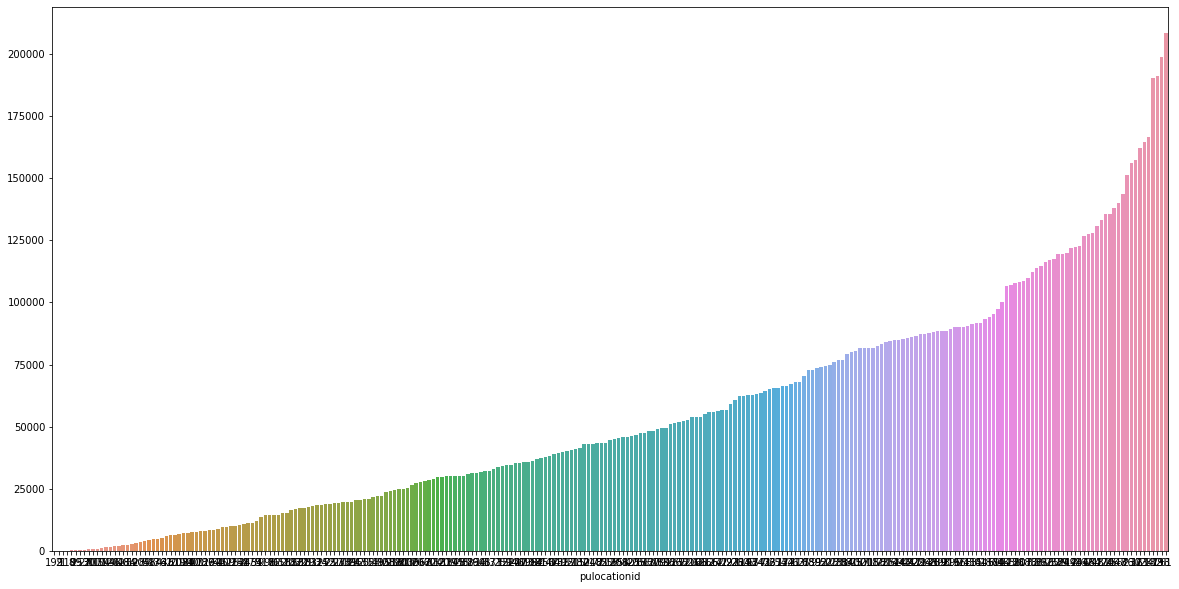

In [58]:
pickups = zone_to_zone.sum(axis=1).sort_values()
#total pickups for each zone, pretty long tailed
plt.figure(figsize=(20,10))
sns.barplot(x = pickups.index.astype(str), y = pickups.values)

In [59]:
#take an example zone, how to create a distribution for its customer arrivals?
#first visualize a few examples

def visualize_zone_pickups_over_month(zone_id):
    zone_trips_ex = zone_groups.get_group(zone_id).copy()
    
    #grouping by hour starting from the first of each month
    zone_trips_ex['hour_of_month'] = zone_trips_ex.hour + 24 * (zone_trips_ex.day - 1)
    arrivals_by_hour_ex = zone_trips_ex.groupby('hour_of_month')['hvfhs_license_num'].count()

    #graphing arrivals per hour over time
    plt.figure(figsize=(20,10))
    sns.lineplot(x = arrivals_by_hour_ex.index, y = arrivals_by_hour_ex.values)

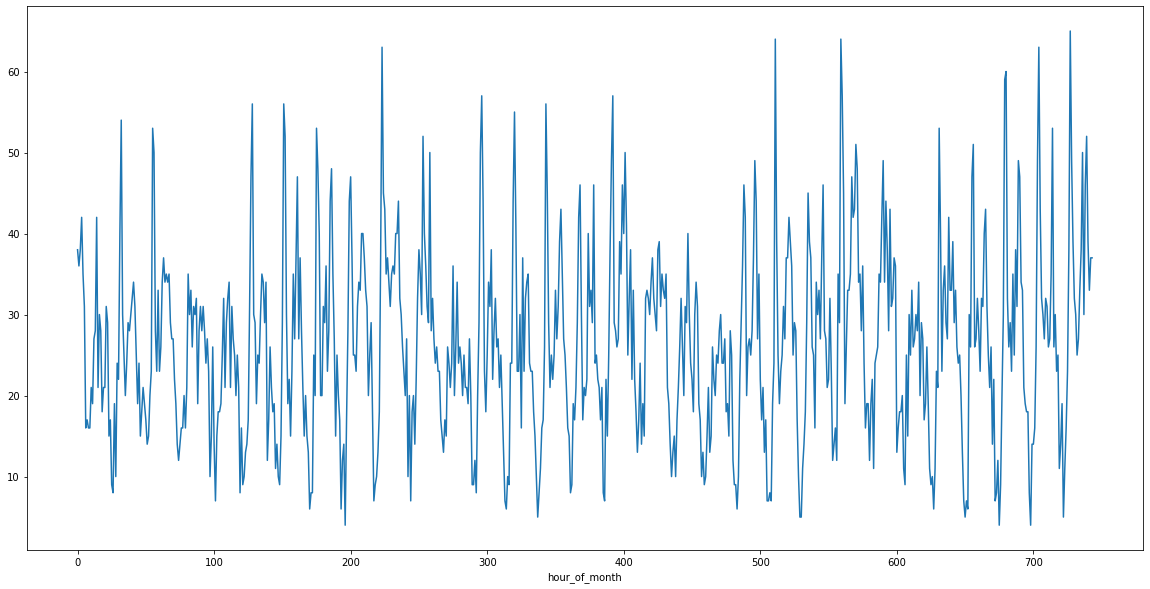

In [60]:
visualize_zone_pickups_over_month(139)

In [61]:
#based on a few examples from above it looks like there isn't too much variation from week to week
#definitely variation within a week/day
#to simplify the problem just fit a rate function to the daily variation for now
def visualize_daily_zone_pickups(zone_id):
    zone_trips_ex = zone_groups.get_group(zone_id).copy()
    
    #divide by 31 days in january
    arrivals_by_hour_ex = zone_trips_ex.groupby('hour')['hvfhs_license_num'].count() / 31

    #graphing arrivals per hour over a day
    plt.figure(figsize=(20,10))
    sns.scatterplot(x = arrivals_by_hour_ex.index, y = arrivals_by_hour_ex.values)

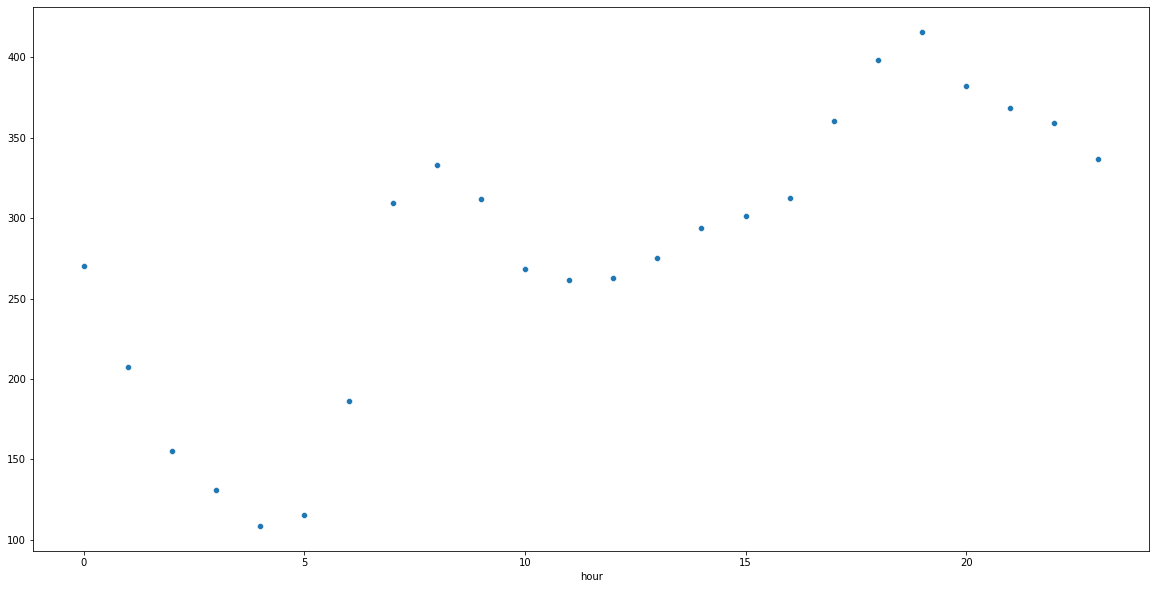

In [62]:
visualize_daily_zone_pickups(61)

In [63]:
def visualize_daily_zone_pickups(zone_id):
    zone_trips_ex = zone_groups.get_group(zone_id).copy()
    
    #divide by 31 days in january
    arrivals_by_hour_ex = zone_trips_ex.groupby('hour')['hvfhs_license_num'].count() / 31

    #graphing arrivals per hour over a day
    plt.figure(figsize=(20,10))
    sns.scatterplot(x = arrivals_by_hour_ex.index, y = arrivals_by_hour_ex.values)

In [64]:
#choice between having a smooth rate function (fitted using polynomials to the data) vs just using
#a constant rate for each hour/minute

#this is an example, basically using an array of size 24 = [average # of pickups in hour 1, average # in 2, ... ]
#calculate the value at any time t
def rate(t, arr):
    #round t and take the corresponding value in arr
    return arr[round(t)]

In [66]:
def extract_zone_daily_information(zone_group):
    #arrival information: array(24)
    arr_by_hour = pd.Series(index = np.arange(0,24), data = np.zeros(24))
    arr_by_hour += zone_group.groupby('hour')['hvfhs_license_num'].count() / 31
    arr_by_hour = arr_by_hour.fillna(0)
    
    #distribution of dropoffs: array(264)
    dist_dropoffs = pd.Series(index = np.arange(1,264), data = np.zeros(263))
    dist_dropoffs += zone_group.groupby('dolocationid')['hvfhs_license_num'].count()
    dist_dropoffs = dist_dropoffs.fillna(0)
    
    return arr_by_hour, dist_dropoffs

extract_zone_daily_information(zone_groups.get_group(139))

(0     17.645161
 1     12.387097
 2     11.451613
 3     14.032258
 4     12.935484
 5     19.741935
 6     24.387097
 7     40.354839
 8     40.774194
 9     31.806452
 10    25.709677
 11    27.258065
 12    25.645161
 13    29.774194
 14    33.451613
 15    32.741935
 16    32.935484
 17    35.322581
 18    35.741935
 19    30.193548
 20    26.806452
 21    25.354839
 22    24.225806
 23    22.354839
 dtype: float64,
 1      4.0
 2      0.0
 3      0.0
 4      1.0
 5      0.0
       ... 
 259    3.0
 260    9.0
 261    1.0
 262    0.0
 263    7.0
 Length: 263, dtype: float64)

In [67]:
from pandarallel import pandarallel

# Initialization
pandarallel.initialize(progress_bar = True)

extracted_information = zone_groups.parallel_apply(extract_zone_daily_information)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [68]:
extracted_information.to_pickle('arrival_and_dropoff_distributions')

<Figure size 1440x720 with 0 Axes>

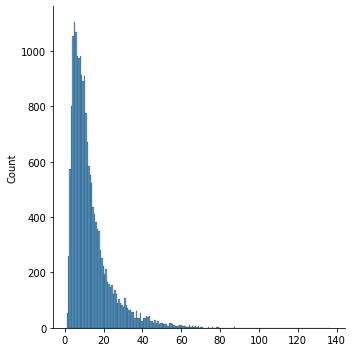

In [69]:
#what do the service time distributions look like, since they tend to vary throughout the day as well
#tend to be exponential-looking, so probably can just use the mean to each zone at first (disregarding the time)
def visualize_service_time_zone(zone_group):
    service_times = zone_group.dropoff_datetime - zone_group.pickup_datetime
    service_times = service_times.dt.seconds / 60
    
    plt.figure(figsize=(20,10))
    sns.displot(x = service_times)

visualize_service_time_zone(zone_groups.get_group(139))

In [70]:
#extracting means of trip times to each drop off zone
def extract_trip_time_means(zone_group):
    
    #this is to make sure the output of each zone group is consistent, since some pickup zones don't have any dropoffs in some zones
    service_times = pd.Series(data = np.zeros(263), index = np.arange(1,264))
    #following line just takes the difference between dropoffs and pickups and calculates the mean of that difference for each dropoff zone
    service_times += zone_group.groupby('dolocationid').apply(lambda g: (g.dropoff_datetime - g.pickup_datetime).dt.seconds.mean() / 60)
    return service_times

extract_trip_time_means(zone_groups.get_group(139))

1      64.916667
2            NaN
3            NaN
4      38.000000
5            NaN
         ...    
259    35.261111
260    34.557407
261    46.116667
262          NaN
263    49.514286
Length: 263, dtype: float64

In [71]:
#NaN values just means there's no data on zone -> zone trips
#all of these are means that can be used to sample from exponential distributions

trip_times = zone_groups.parallel_apply(extract_trip_time_means)

In [72]:
trip_times.to_csv('trip_time_means.csv')